# Run all the experiments for the MRMR paper

Performs all the experiments. 

In [1]:
import sys
sys.path.append("../..")
from exp_run_config import Config
Config.PROJECTNAME = "WaterBerryFarms"

import pathlib
from pprint import pprint
import gzip as compress
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

import wbf_figures
from wbf_simulate import run_nrobot1day

from information_model import StoredObservationIM

In [2]:
experiment = "mrmr"
lookup = {"mrmr-clustered-1pio-2con": "MRMR", "mrmr-clustered-3lawnmowers": "MRSE", "mrmr-clustered-3random": "MRRW", "mrmr-unclustered-1pio-2con" : "MRMR",
"mrmr-unclustered-3lawnmowers": "MRSE", "mrmr-unclustered-3random": "MRRW"}

In [3]:
# the experiment for this notebook
expall = Config().get_experiment(experiment, "mrmr_all")

for run in expall["allruns"]:
    exp = Config().get_experiment(experiment, run)
    pprint(exp)
    run_nrobot1day(exp)



***ExpRun**: Loading pointer config file:
	C:\Users\lboloni\.config\WaterBerryFarms\mainsettings.yaml
***ExpRun**: Loading machine-specific config file:
	G:\My Drive\LotziStudy\Code\PackageTracking\WaterBerryFarms\settings\WBF-config-LotziYoga.yaml
***ExpRun**: Configuration for exp/run: mrmr/mrmr_all successfully loaded
***ExpRun**: Configuration for exp/run: mrmr/mrmr-clustered-3random successfully loaded
Experiment:
    data_dir: C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr-clustered-3random
    exp_environment: mrmr-custom-clustered
    exp_estimator: adaptive-disk
    exp_run_sys_indep_file: C:\Users\lboloni\Documents\Code\_Checkouts\WBF\WaterberryFarms\experiment_configs\mrmr\mrmr-clustered-3random.yaml
    exp_score: weighted_asymmetric
    experiment_name: mrmr
    im_resolution: 10
    name: 3 random waypoint
    robots:
    - exp-policy: random-waypoint
      exp-policy-extra-parameters:
        budget: 1000
        name: rwp-1
        seed: 1
      

In [4]:
# load back all the results 
all_results = {}

for run in expall["allruns"]:
    exp = Config().get_experiment(experiment, run)
    pprint(exp)

    resultsfile = pathlib.Path(exp["data_dir"], "results.pickle")
    if not resultsfile.exists():
        print(f"Results file does not exist:\n{resultsfile}")
        print("Run the notebook Run-1Robot1Day with the same exp/run to create it.")
        raise Exception("Nothing to do.")

    # load the results file
    with compress.open(resultsfile, "rb") as f:
        results = pickle.load(f)    
    all_results[run] = results


***ExpRun**: Configuration for exp/run: mrmr/mrmr-clustered-3random successfully loaded
Experiment:
    data_dir: C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr-clustered-3random
    exp_environment: mrmr-custom-clustered
    exp_estimator: adaptive-disk
    exp_run_sys_indep_file: C:\Users\lboloni\Documents\Code\_Checkouts\WBF\WaterberryFarms\experiment_configs\mrmr\mrmr-clustered-3random.yaml
    exp_score: weighted_asymmetric
    experiment_name: mrmr
    im_resolution: 10
    name: 3 random waypoint
    robots:
    - exp-policy: random-waypoint
      exp-policy-extra-parameters:
        budget: 1000
        name: rwp-1
        seed: 1
      name: robot-1
    - exp-policy: random-waypoint-seed10
      exp-policy-extra-parameters:
        budget: 1000
        name: rwp-2
        seed: 10
      name: robot-2
    - exp-policy: random-waypoint-seed20
      exp-policy-extra-parameters:
        budget: 1000
        name: rwp-3
        seed: 20
      name: robot-3
 

In [5]:
all_results.keys()

dict_keys(['mrmr-clustered-3random', 'mrmr-clustered-3lawnmowers', 'mrmr-clustered-1pio-2con', 'mrmr-unclustered-3random', 'mrmr-unclustered-3lawnmowers', 'mrmr-unclustered-1pio-2con'])

### Visualize the replanning process
* for all the mrmr scenarios, for the contractor agents
* for all the replanning points (which are the indexes of the oldplans dictionary)
* create a figure
* visualize the observations to that time with a continuous line
* visualize the rest of the plan from the oldplans

__FIXME__: There is some kind of problem about how the position of the robot is drawn. Somehow the robot position does not align with the end of the trajectory, no matter how I am taking the robot position from. May 8, 2025, I have turned this off, because it is more important to submit the paper, I will debug it later.

In [6]:
def show_robot_with_plan(expall, scenario, results, robotno, t):
    """Visualize the plan of the robot at a certain time point"""

    ROBOT_COLORS = ["#E69F00", "#56B4E9", "#009E73"]
    robot_color = ROBOT_COLORS[2]

    robot = results["robots"][robotno]
    observations = [o[robotno] for o in results["observations"]]
    observations = observations[0:int(t)]
    if observations:
        print(f"Last observations: {observations[-1]}")

    oldplan = robot.oldplans[t]


    filename = f"plans_{scenario}_{robot.name}_{t}"

    fig, ax = plt.subplots(1,1, figsize=(3, 3))
    wbf_figures.show_env_tylcv(results, ax)
    # obs = observations[1:int(t)]
    # color = "blue"
    wbf_figures.show_individual_robot_path(results, ax, robot=robot, observations=observations, pathcolor=robot_color, pathwidth=1,  draw_robot=False, robotcolor=robot_color, from_obs=0, to_obs=int(t))

    # add the plan
    # print(f"Oldplan beginning: {oldplan[0]}")
    planx = [a["x"] for a in oldplan]
    plany = [a["y"] for a in oldplan]
    ax.add_line(matplotlib.lines.Line2D(planx, plany, color = robot_color, linestyle=":", linewidth=1))

    # position of the robot
    # ax.add_patch(matplotlib.patches.Circle((observations[int(t)]["x"], observations[int(t)]["y"]), radius=3, facecolor=robot_color))
    # ax.add_patch(matplotlib.patches.Circle((observations[-1]["x"], observations[-1]["y"]), radius=3, facecolor=robot_color))
    # ax.add_patch(matplotlib.patches.Circle((oldplan[0]["x"], oldplan[0]["y"]), radius=3, facecolor="yellow"))

    ax.set_title(f"{robot.name} at t={int(t)}")
    filepath = pathlib.Path(expall.data_dir(), f"{filename}.pdf")
    plt.savefig(filepath)
    print(f"Done saving to {filepath}")

Last observations: {'x': 88, 'y': 28, 'time': 645, 'TYLCV': {'x': 88, 'y': 28, 'time': 645, 'value': np.float64(1.0)}, 'CCR': {'x': 88, 'y': 28, 'time': 645, 'value': np.float64(0.0)}, 'Soil': {'x': 88, 'y': 28, 'time': 645, 'value': np.float64(0.0)}, 'name': 'mrmr-contractor-2'}
Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-clustered-1pio-2con_con-2_646.0.pdf


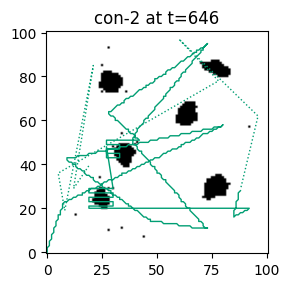

In [7]:
import logging
logging.getLogger("fontTools").setLevel(logging.WARNING)


scenario = "mrmr-clustered-1pio-2con"
results = all_results[scenario]
robotno = 2
oldplans = results["robots"][robotno].oldplans
#for t in oldplans:
#    print(t)
show_robot_with_plan(expall, scenario, results, robotno, 646.0)

In [8]:
obs = results["observations"]
obs[4]

[{'x': 1,
  'y': 3,
  'time': 4,
  'TYLCV': {'x': 1, 'y': 3, 'time': 4, 'value': np.float64(1.0)},
  'CCR': {'x': 1, 'y': 3, 'time': 4, 'value': np.float64(0.0)},
  'Soil': {'x': 1, 'y': 3, 'time': 4, 'value': np.float64(0.0)},
  'name': 'mrmr-pioneer'},
 {'x': 2,
  'y': 2,
  'time': 4,
  'TYLCV': {'x': 2, 'y': 2, 'time': 4, 'value': np.float64(1.0)},
  'CCR': {'x': 2, 'y': 2, 'time': 4, 'value': np.float64(0.0)},
  'Soil': {'x': 2, 'y': 2, 'time': 4, 'value': np.float64(0.0)},
  'name': 'mrmr-contractor-1'},
 {'x': 1,
  'y': 3,
  'time': 4,
  'TYLCV': {'x': 1, 'y': 3, 'time': 4, 'value': np.float64(1.0)},
  'CCR': {'x': 1, 'y': 3, 'time': 4, 'value': np.float64(0.0)},
  'Soil': {'x': 1, 'y': 3, 'time': 4, 'value': np.float64(0.0)},
  'name': 'mrmr-contractor-2'}]

con-1
0.0
Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-clustered-1pio-2con_con-1_0.0.pdf
211.0
Last observations: {'x': 36, 'y': 33, 'time': 210, 'TYLCV': {'x': 36, 'y': 33, 'time': 210, 'value': np.float64(1.0)}, 'CCR': {'x': 36, 'y': 33, 'time': 210, 'value': np.float64(0.0)}, 'Soil': {'x': 36, 'y': 33, 'time': 210, 'value': np.float64(0.0)}, 'name': 'mrmr-contractor-1'}
Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-clustered-1pio-2con_con-1_211.0.pdf
271.0
Last observations: {'x': 34, 'y': 46, 'time': 270, 'TYLCV': {'x': 34, 'y': 46, 'time': 270, 'value': np.float64(0.0)}, 'CCR': {'x': 34, 'y': 46, 'time': 270, 'value': np.float64(0.0)}, 'Soil': {'x': 34, 'y': 46, 'time': 270, 'value': np.float64(0.0)}, 'name': 'mrmr-contractor-1'}
Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-clustered-1pio-2con_con-1_271.0.pdf
377.0
L

C:\Users\lboloni\AppData\Local\Temp\ipykernel_40780\976710211.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,1, figsize=(3, 3))


Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-unclustered-1pio-2con_con-2_0.0.pdf
802.0
Last observations: {'x': 3, 'y': 70, 'time': 801, 'TYLCV': {'x': 3, 'y': 70, 'time': 801, 'value': np.float64(1.0)}, 'CCR': {'x': 3, 'y': 70, 'time': 801, 'value': np.float64(0.0)}, 'Soil': {'x': 3, 'y': 70, 'time': 801, 'value': np.float64(0.0)}, 'name': 'mrmr-contractor-2'}
Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-unclustered-1pio-2con_con-2_802.0.pdf
829.0
Last observations: {'x': 18, 'y': 96, 'time': 828, 'TYLCV': {'x': 18, 'y': 96, 'time': 828, 'value': np.float64(1.0)}, 'CCR': {'x': 18, 'y': 96, 'time': 828, 'value': np.float64(0.0)}, 'Soil': {'x': 18, 'y': 96, 'time': 828, 'value': np.float64(0.0)}, 'name': 'mrmr-contractor-2'}
Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-unclustered-1pio-2con_con-2_829.0.pdf
859.0
Last obse

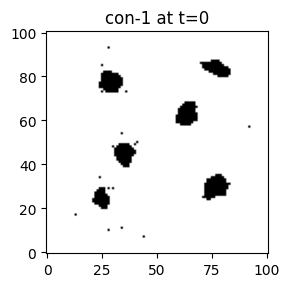

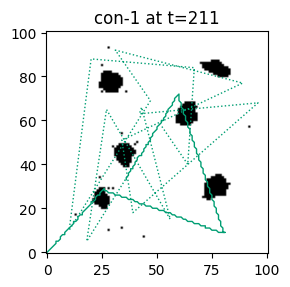

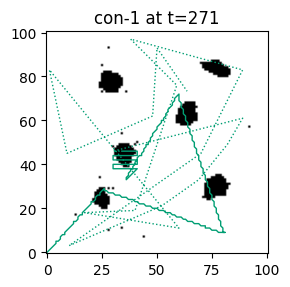

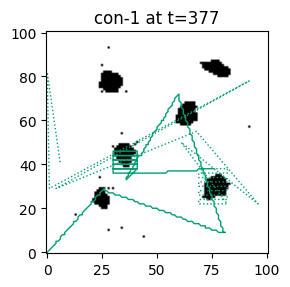

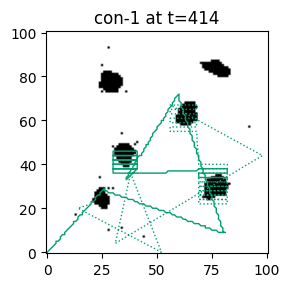

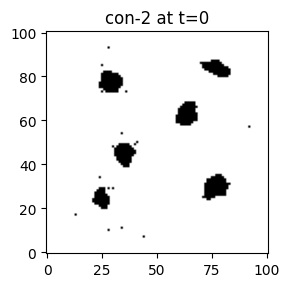

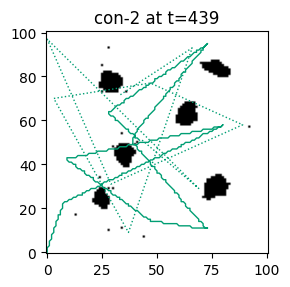

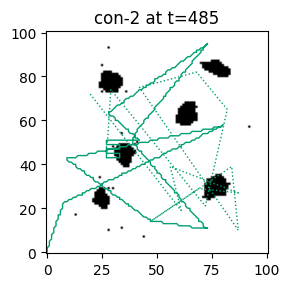

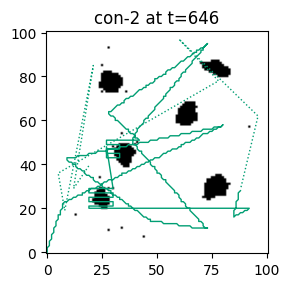

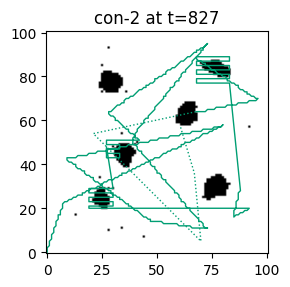

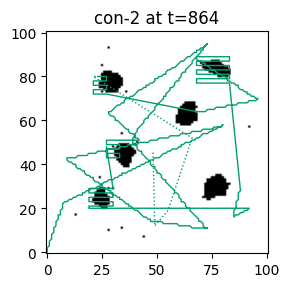

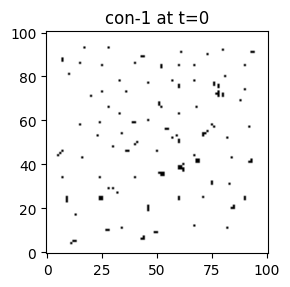

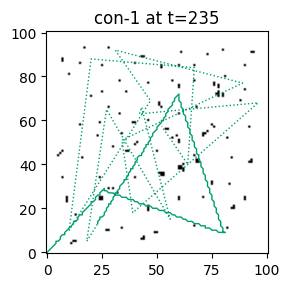

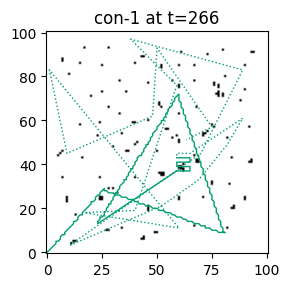

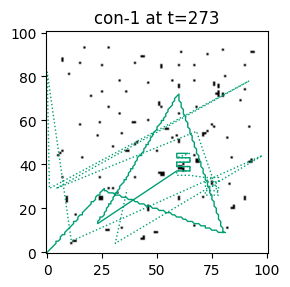

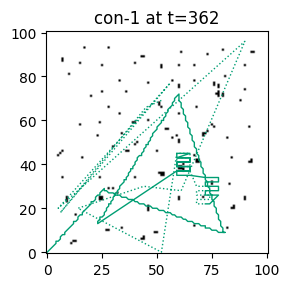

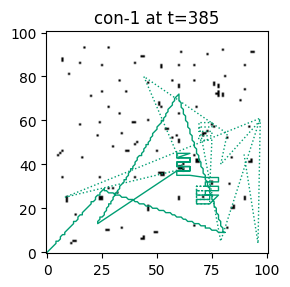

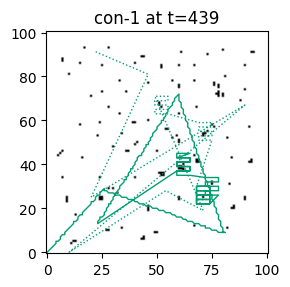

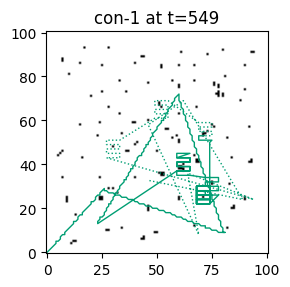

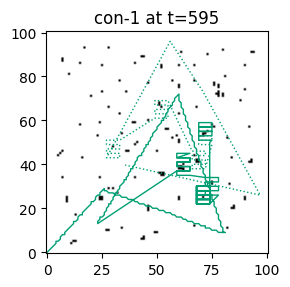

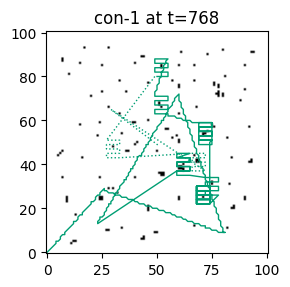

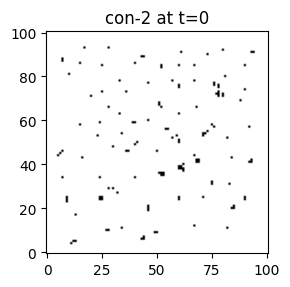

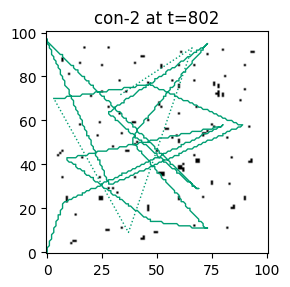

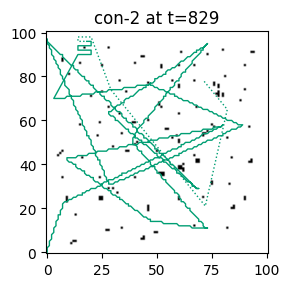

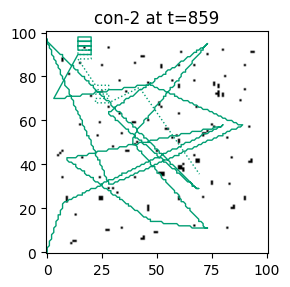

In [9]:
for scenario in all_results:
    if "1pio" not in scenario: continue
    results = all_results[scenario]
    for i, robot in enumerate(results["robots"]):
        if "con" in robot.name:
            print(robot.name)
            # FIXME: I think that the problem here is that I won't have access to the policy here, so I will need to store the old plans somewhere else... maybe in the robot...?
            oldplans = robot.oldplans
            for t in oldplans:
                print(t)
                show_robot_with_plan(expall, scenario, results, i, t)

### Visualize detection paths 
* for all running scenarios
* create a graph for the visualization of the paths, with the visualize the detections
* create a bargraph with the number of detection points for each of them
* FIXME: maybe also visualize the money for the mrmr agents

In [10]:
def show_robot_trajectories_and_detections(expall, name, results, robot_colors):

    fig, ax = plt.subplots(1,1, figsize=(3, 3))
    wbf_figures.show_env_tylcv(results, ax)
    ax.set_title(lookup[name])
    custom_lines = []
    labels = []

    for i, robot in enumerate(results["robots"]):
        color = robot_colors[i % len(results["robots"])]
        observations = [o[i] for o in results["observations"]]
        wbf_figures.show_individual_robot_path(results, ax, robot=robot, observations=observations, pathcolor=color, draw_robot=False)
        wbf_figures.show_individual_robot_detections(results, ax, robotno=i, detection_color=color, radius=0.5)
        # adding to the legend
        custom_lines.append(matplotlib.lines.Line2D([0], [0], color=color, lw=2))
        labels.append(robot.name)


    # Add both automatic and manual entries to the legend
    ax.legend(handles=[*custom_lines], labels=labels, ncol=3, bbox_to_anchor=(0.5, -0.1), loc="upper center", fontsize="9", columnspacing=0.5, labelspacing=0.5)
    #bbox_to_anchor=(0.5, 0))
             #, loc="upper center")

    # fig.legend(handles, labels, ncol=len(exps)+1,
    #        bbox_to_anchor=(0.5, 0), loc="upper center")

    plt.savefig(pathlib.Path(expall.data_dir(), f"detections-map-{name}.pdf"))

    plt.close()

In [11]:
def count_detections(results, robotno, field = "TYLCV"):
    """Returns the number of detections for the specified robot, adapted from wbf_figures.show_detections"""
    obs = np.array(results["observations"])[:, robotno]
    detections = [[a[StoredObservationIM.X], a[StoredObservationIM.Y]] for a in obs if a[field][StoredObservationIM.VALUE] == 0.0]
    return len(detections)

In [12]:
def show_agentwise_detections(expall, name, results, robot_colors):    
    fig, ax = plt.subplots(1,1, figsize=(3, 1.4))
    # ax.set_title(lookup[name])
    total = 0
    if "unclustered" in name:
        ax.set_ylim(0, 100)
    else:
        ax.set_ylim(0, 600)
    for i, robot in enumerate(results["robots"]):
        detections = count_detections(results, i)
        total += detections
        br = ax.bar(robot.name, detections, color=robot_colors[i])
    ax.bar("Total", total, color="gray")
    plt.savefig(pathlib.Path(expall.data_dir(), f"detections-bar-{name}.pdf"))
    

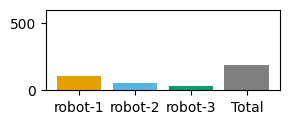

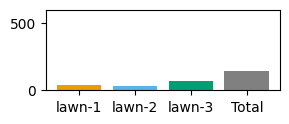

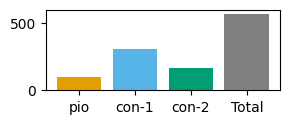

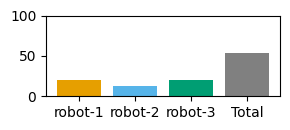

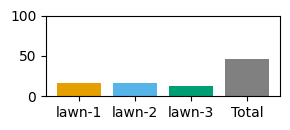

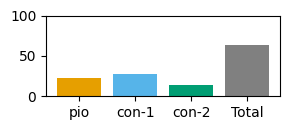

In [13]:
#ROBOT_COLORS = ["red", "blue", "green"]
ROBOT_COLORS = ["#E69F00", "#56B4E9", "#009E73"]
for scenario in all_results:
    results = all_results[scenario]
    name = scenario
    show_robot_trajectories_and_detections(expall, name, results, robot_colors=ROBOT_COLORS)    
    show_agentwise_detections(expall, name, results, robot_colors = ROBOT_COLORS)

### Overall pickings comparison graphs 
* compare the unclustered and clustered cases 
* create comparison graphs

In [14]:
name_colors = ["#CC6666", "#9999CC", "#66CC99"]

In [15]:
def show_comparative_detections(expall, name, values):    
    fig, ax = plt.subplots(1,1, figsize=(3, 3))
    ax.set_ylim(0, 600)
    for i, policyname in enumerate(values):
        br = ax.bar(lookup[policyname], values[policyname], color=name_colors[i])
    plt.savefig(pathlib.Path(expall.data_dir(), f"comparative-bar-{name}.pdf"))

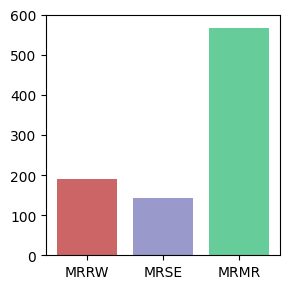

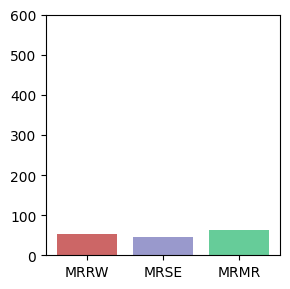

In [16]:
for group in ["clustered-runs", "unclustered-runs"]:
    values = {}
    for scenario in expall[group]:
        results = all_results[scenario]
        total = 0
        for i, robot in enumerate(results["robots"]):
            detections = count_detections(results, i)
            total += detections
        values[scenario] = total
    show_comparative_detections(expall, f"comparative-{group}", values)